In [1]:
import collections
import concurrent.futures as cf
import datetime
import gc
import itertools
import math
from pathlib import Path
import pickle

import IPython.display as ipd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.compute
import pyarrow.parquet as pq
import seaborn as sns
from tqdm.auto import tqdm
import torch

from geo_transformers import geo_utils
from geo_transformers.trajectory import TrajectoryDataset, SimpleTrajectoryProcessor

In [2]:
data_df = pq.read_table("../data/movebank+ungulates/locations_12h/", filters=[("section", "==", "train")]).to_pandas()

In [3]:
individuals_df = pq.read_table("../data/movebank+ungulates/individuals.parquet").to_pandas()

In [4]:
data_df = data_df.join(individuals_df.set_index("id")[["taxon"]], on="individual_id")

In [5]:
def add_vars(df):
    df = df.sort_values(by="timestamp")
    df2 = pd.concat([df.shift(1).add_suffix("_1"), df.add_suffix("_2")], axis=1)
    # NB: we want the *final* bearing (i.e. when arriving at the current location),
    # so we get the one in the opposite direction and reverse it
    df = df.assign(
        dtime=df2["timestamp_2"] - df2["timestamp_1"],
        distance=geo_utils.gcs_to_distance(
            *df2[["location_lat_1", "location_long_1", "location_lat_2", "location_long_2"]].to_numpy().T),
        bearing=geo_utils.gcs_to_bearing(
            *df2[["location_lat_2", "location_long_2", "location_lat_1", "location_long_1"]].to_numpy().T)
    )
    df = df.eval("bearing = (bearing + 180) % 360")
    df = df.eval("turning_angle = (bearing - bearing.shift(1) + 360 + 180) % 360 - 180")
    return df.dropna()
data_df = data_df.groupby("seq_id").apply(add_vars).reset_index(drop=True)

In [6]:
# Find root mean squared distance to target
rms_distance = (data_df["distance"] ** 2).mean() ** 0.5
print(f"RMS distance: {rms_distance} = 1 / {1 / rms_distance}")

RMS distance: 34723.30898157643 = 1 / 2.8799098626533034e-05


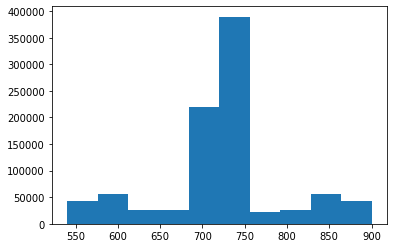

In [7]:
plt.hist(data_df["dtime"].dt.total_seconds() / 60, bins=10)
plt.show()

In [14]:
def dict_to_long_df(data, value_col="value", var_col="var"):
    return pd.concat([
        pd.DataFrame.from_dict({value_col: val, var_col: key})
        for key, val in data.items()
    ], axis=0, ignore_index=True)

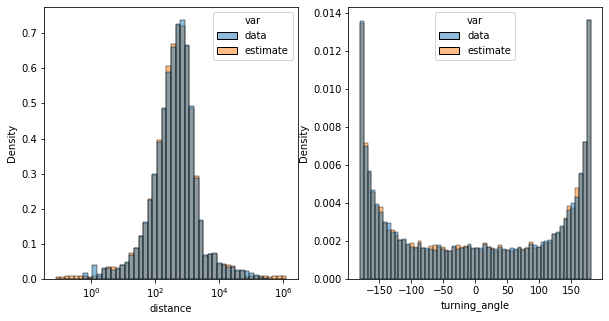

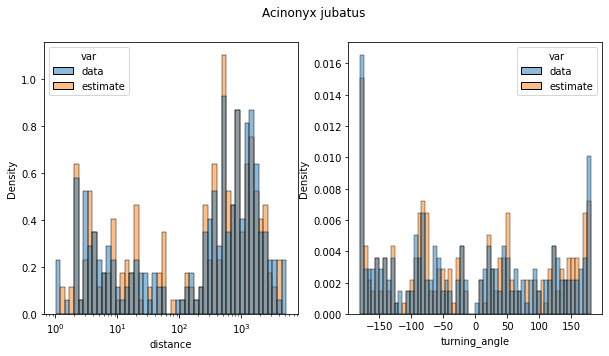

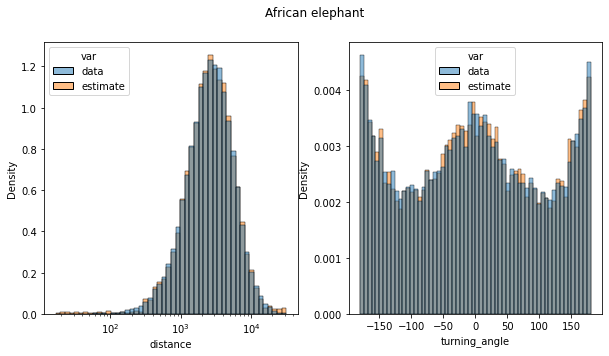

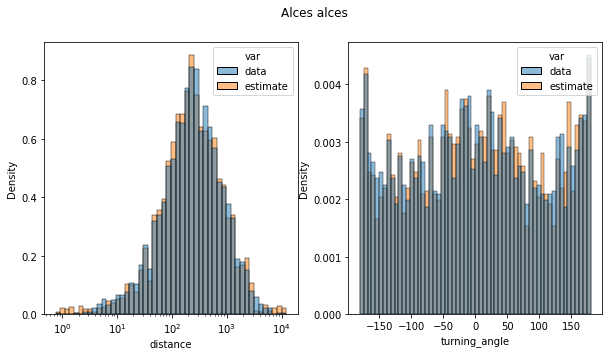

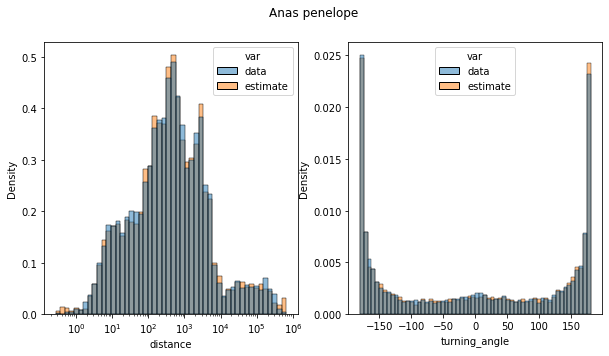

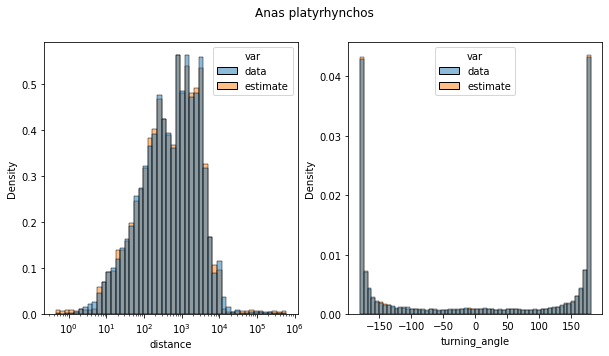

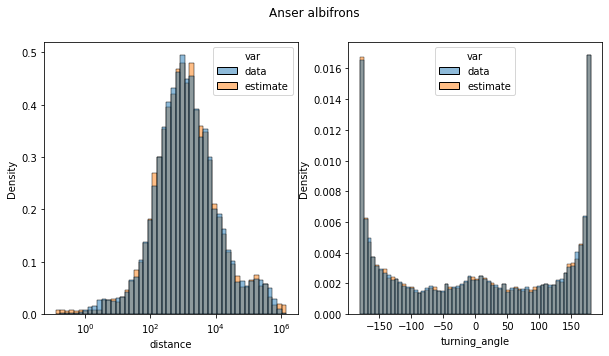

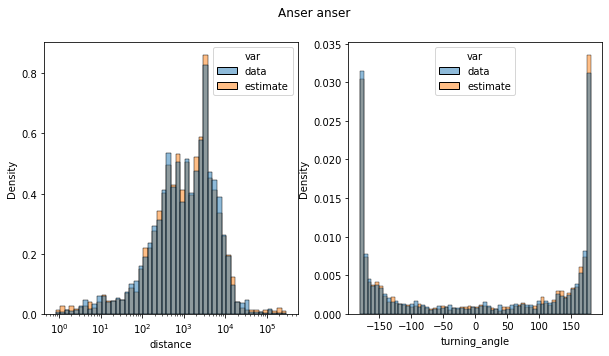

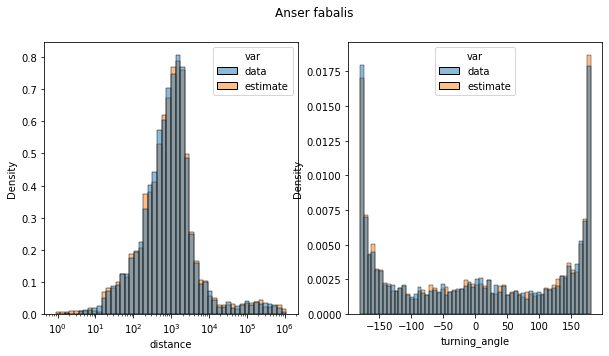

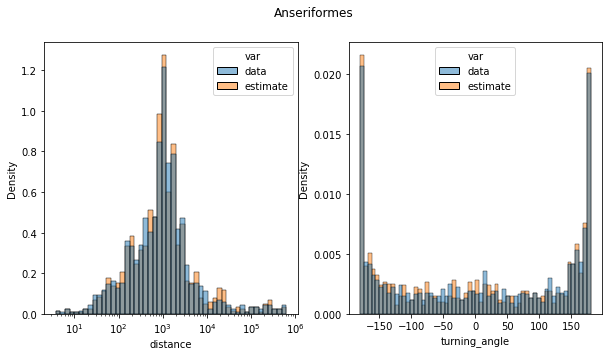

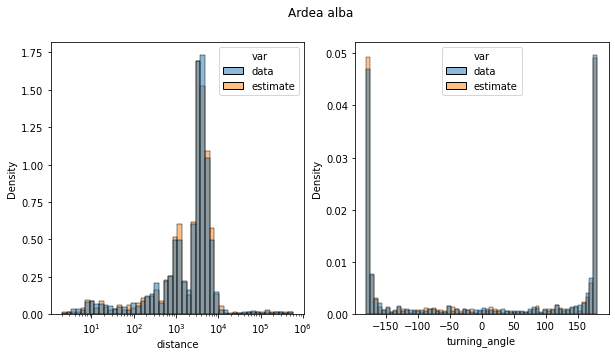

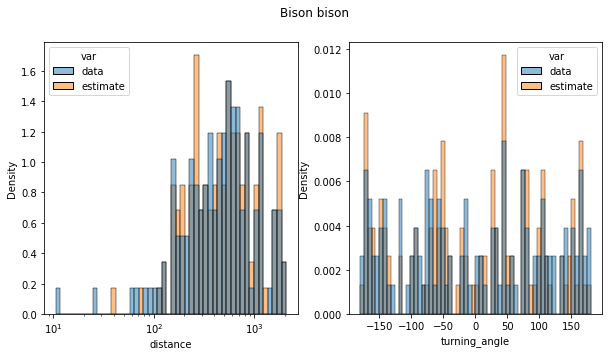

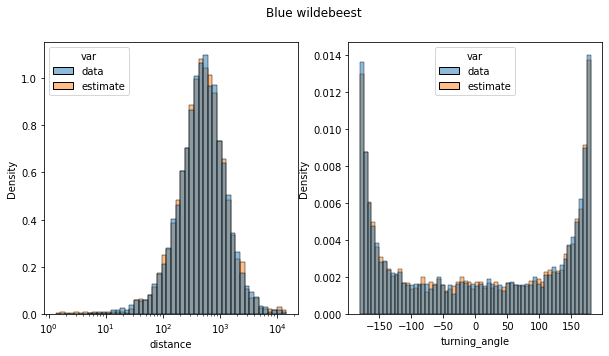

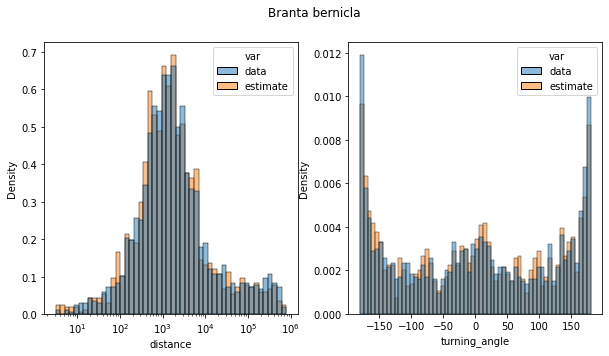

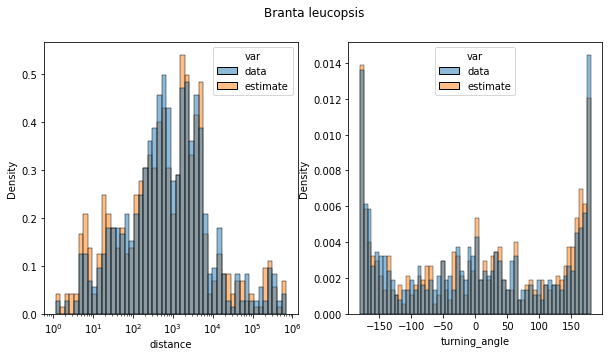

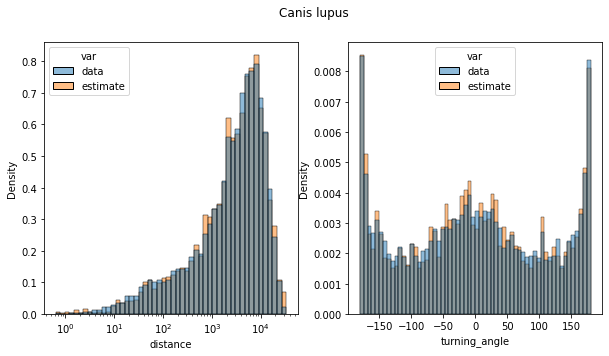

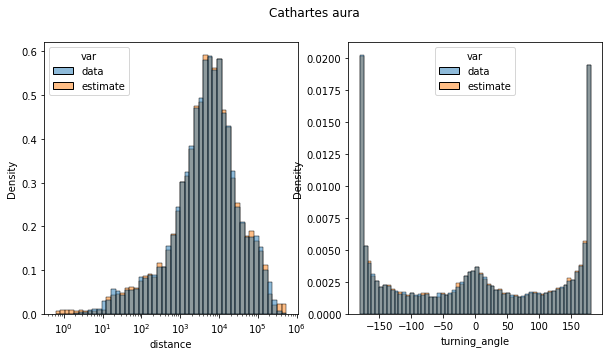

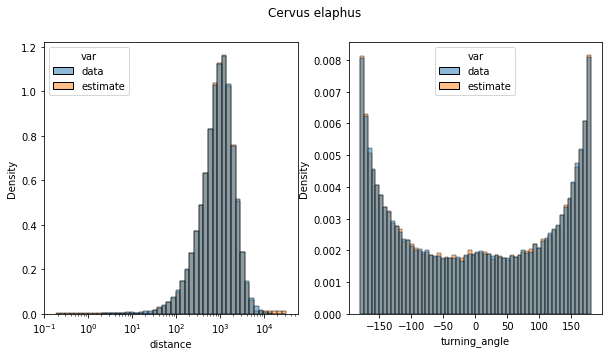

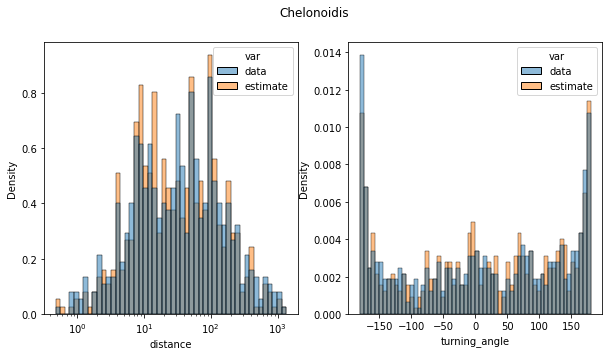

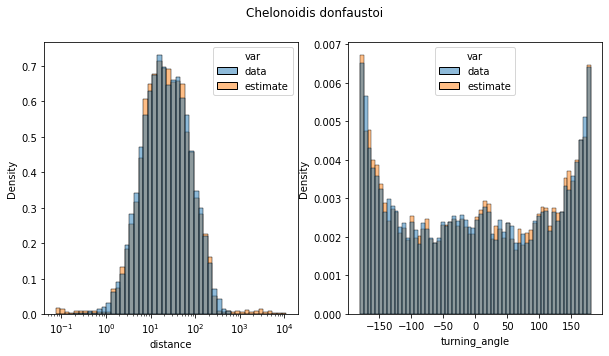

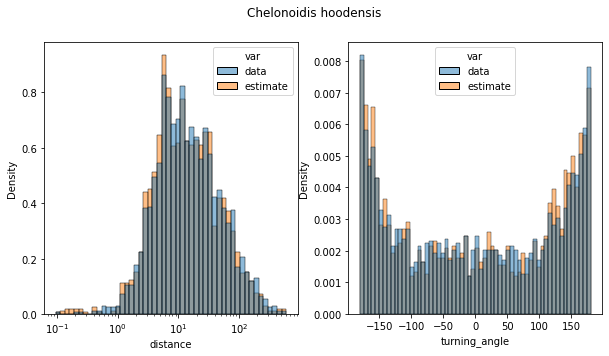

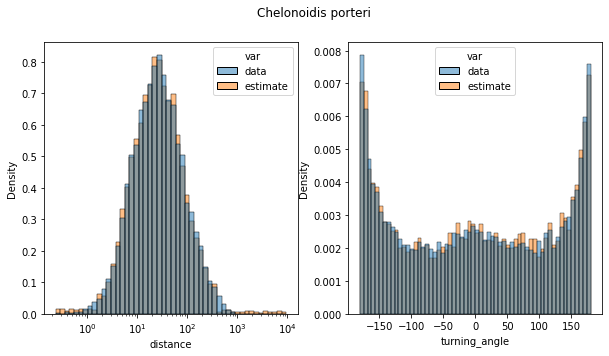

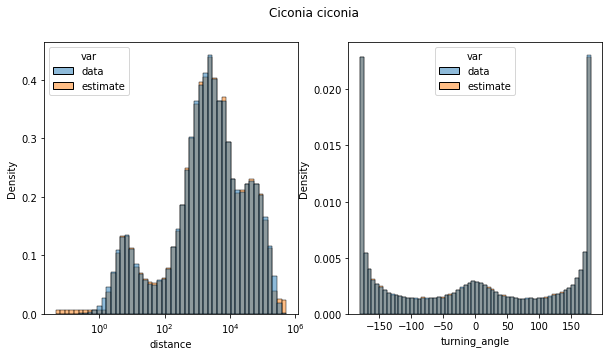

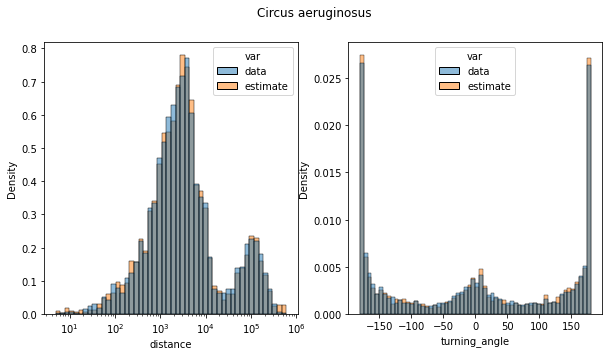

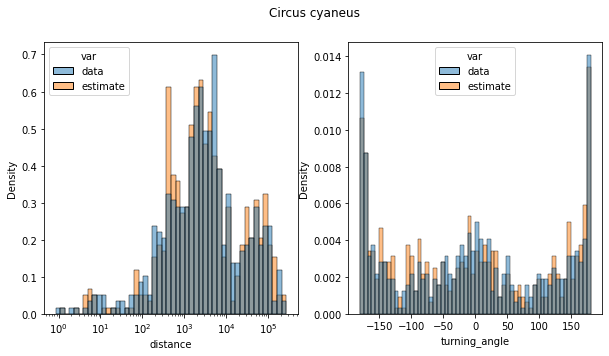

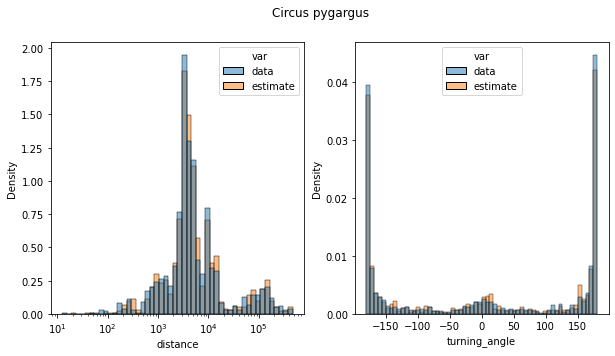

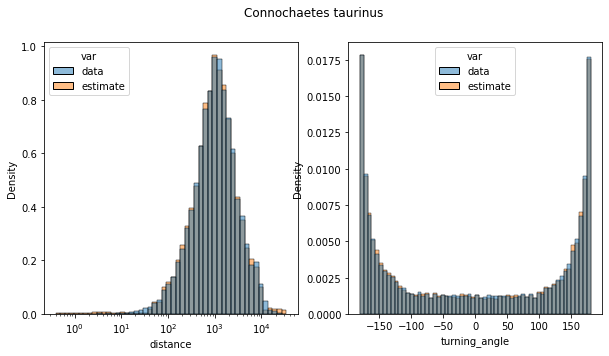

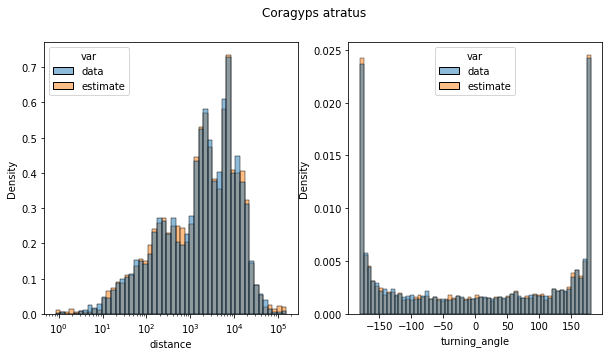

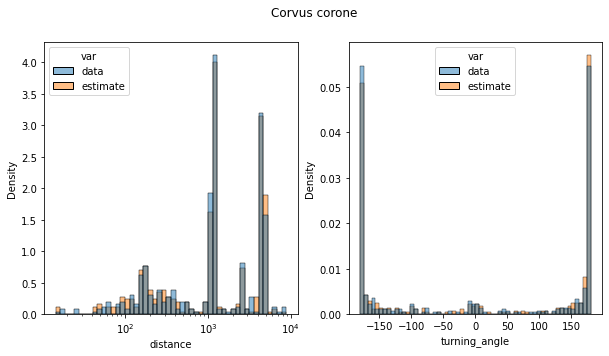

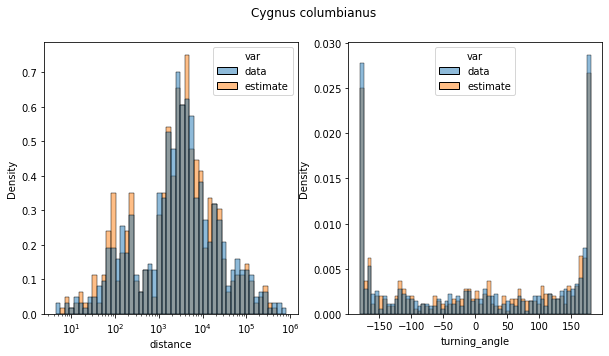

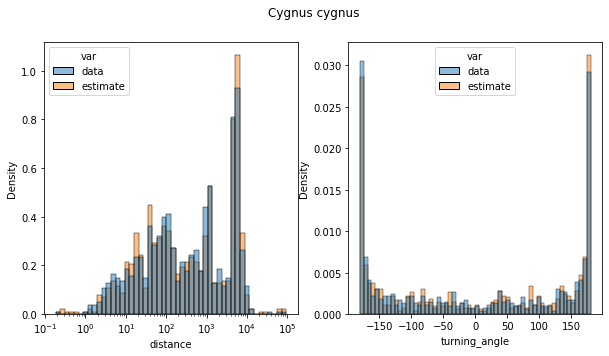

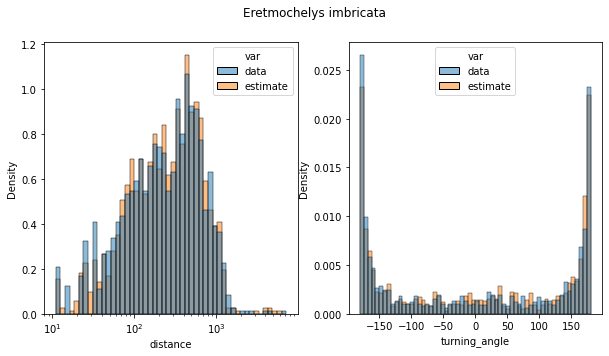

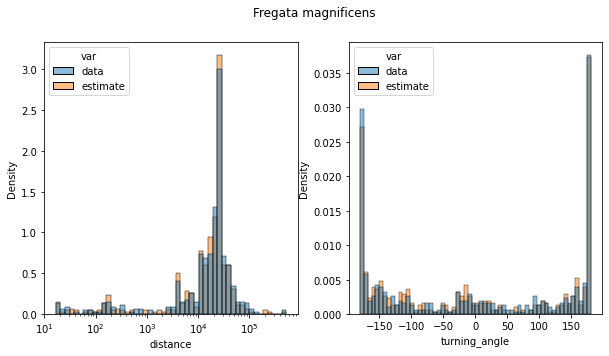

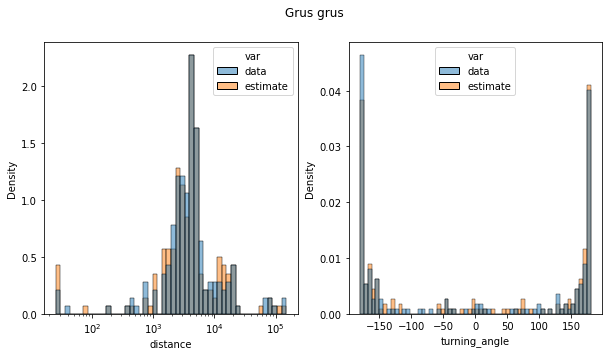

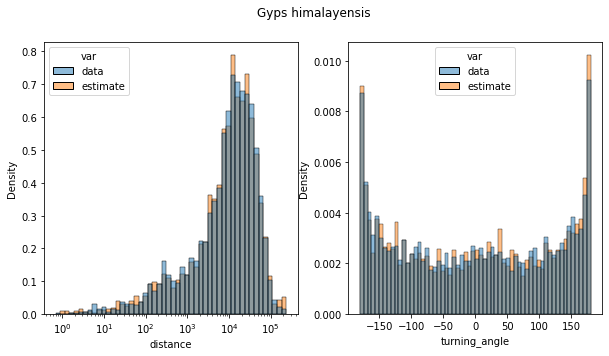

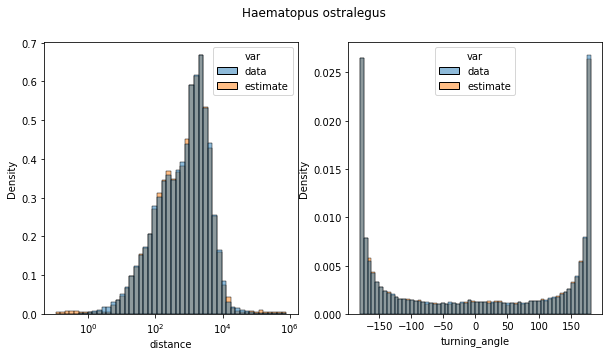

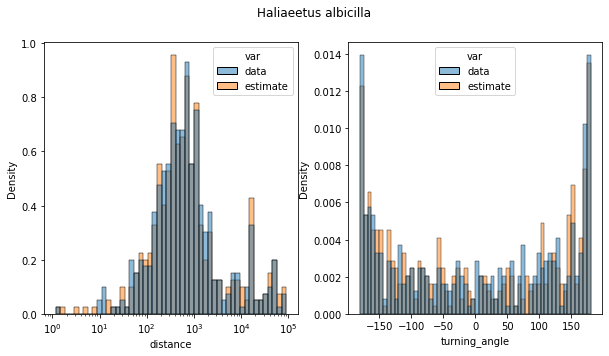

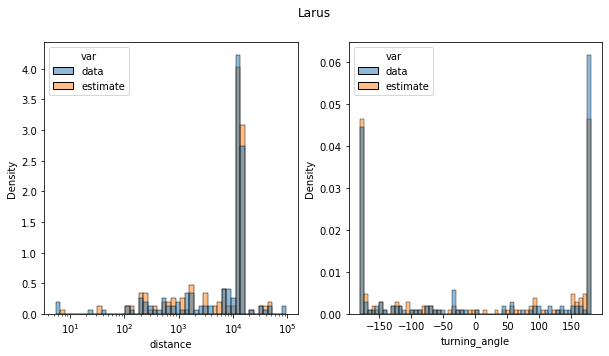

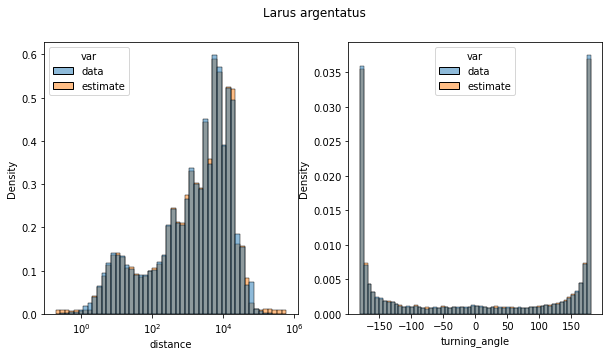

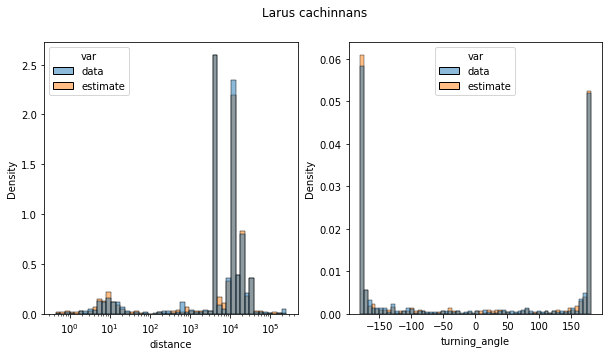

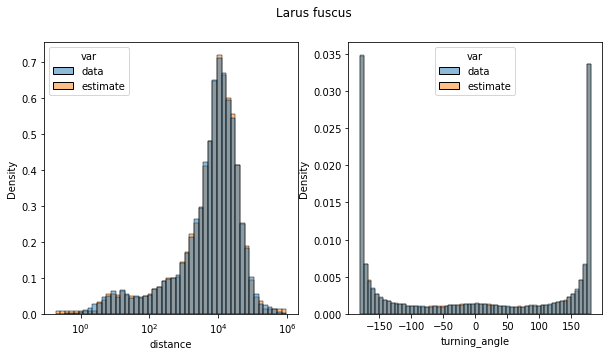

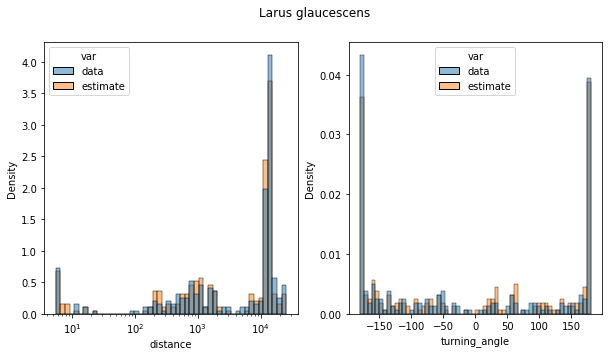

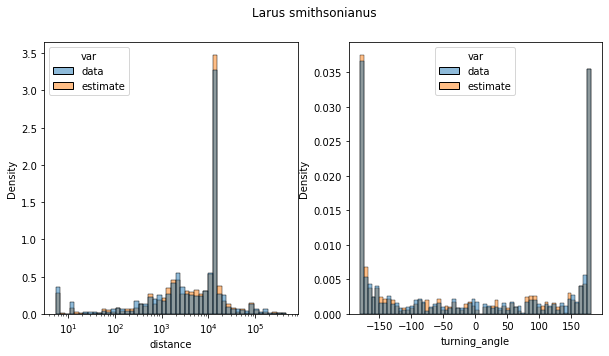

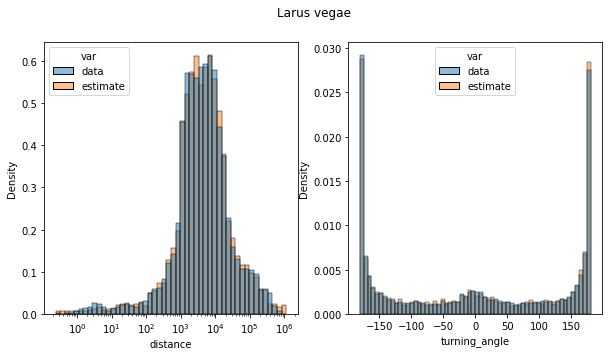

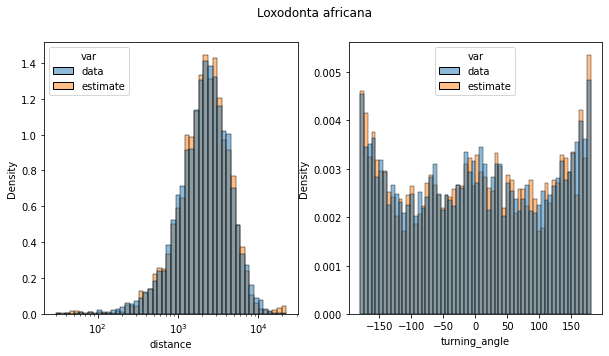

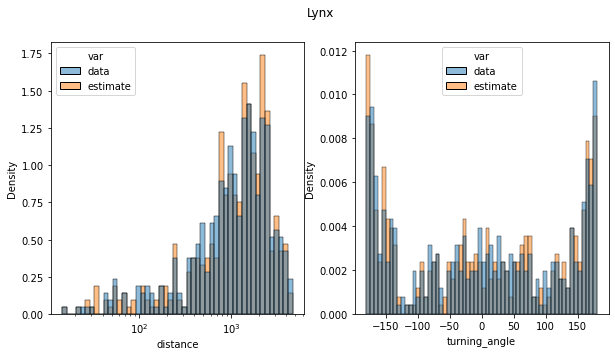

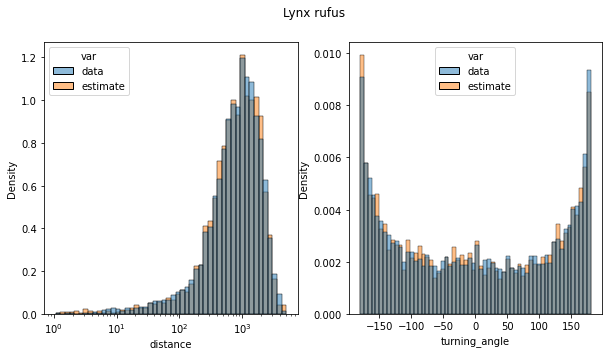

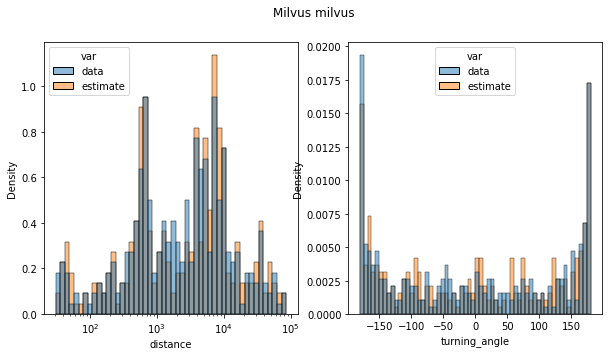

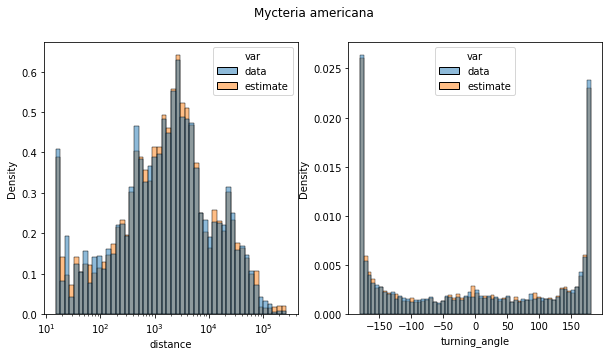

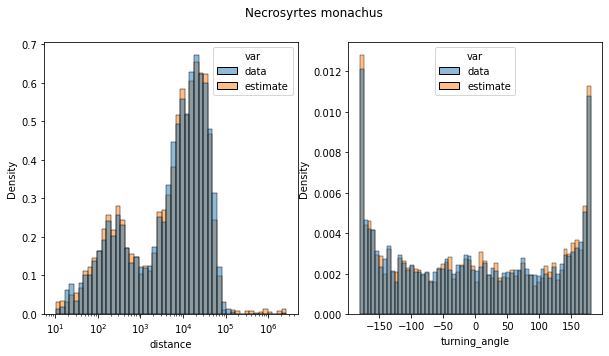

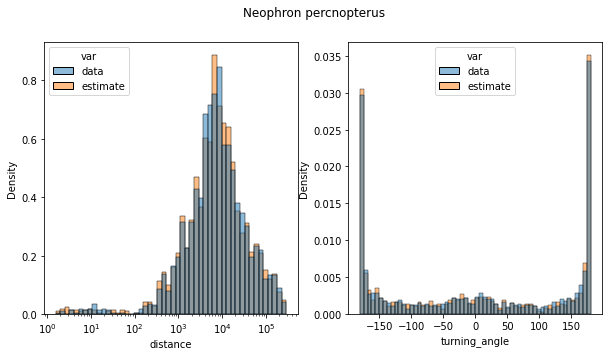

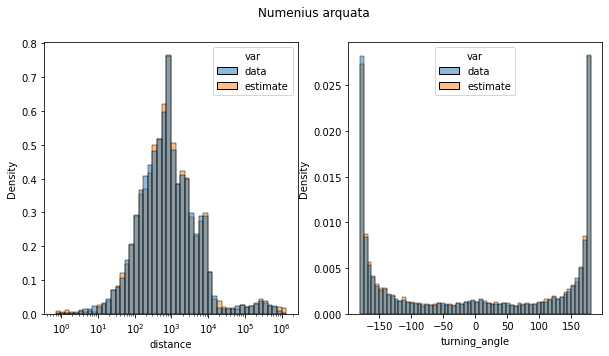

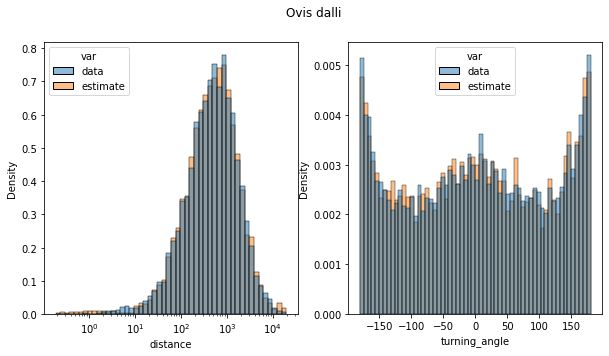

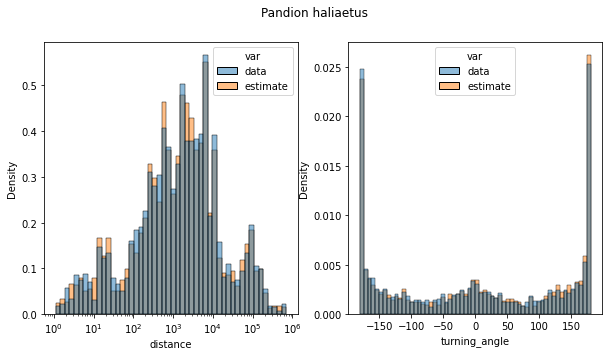

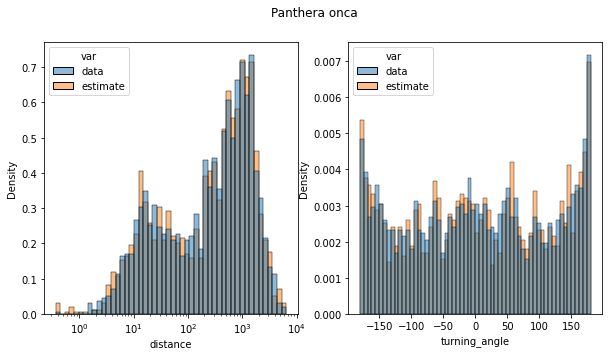

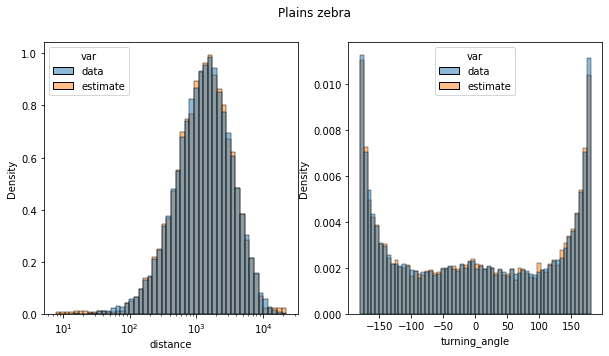

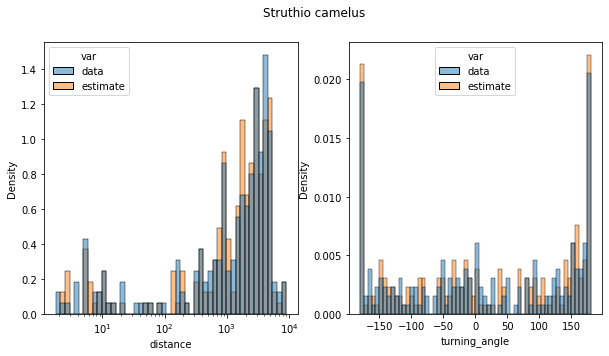

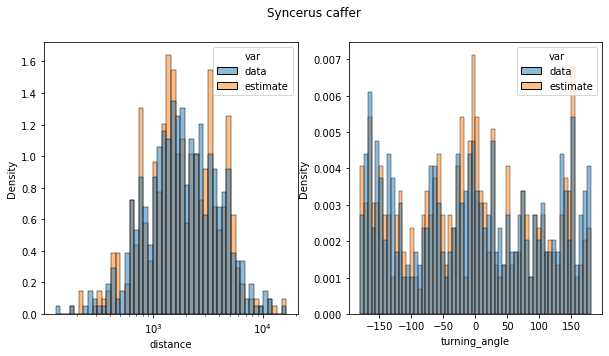

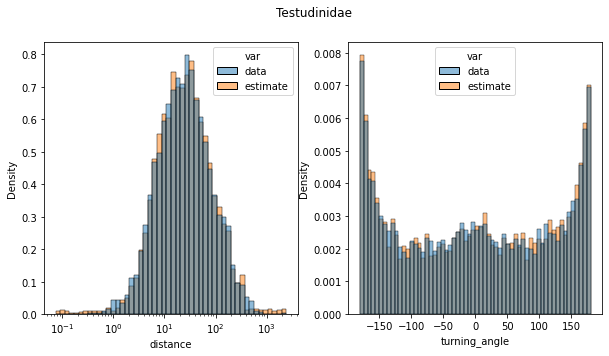

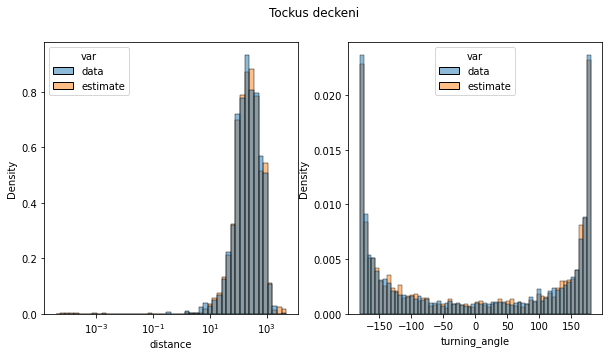

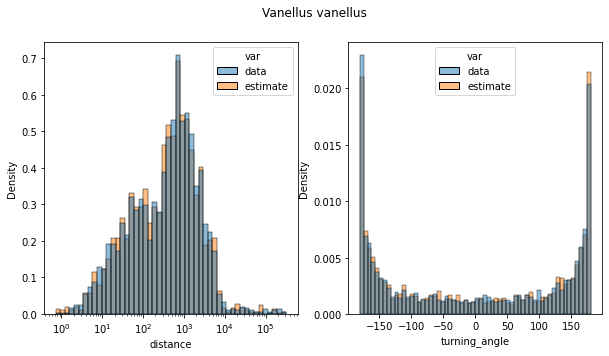

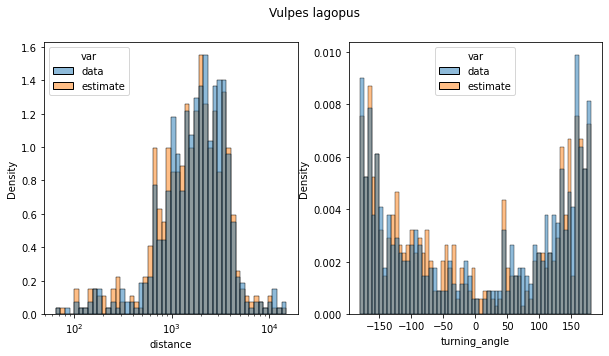

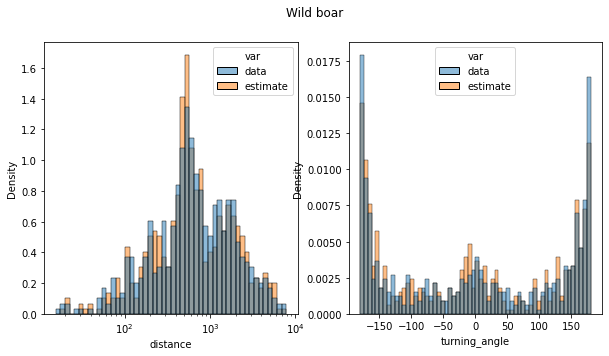

In [15]:
quantiles_x = np.linspace(0, 1, 101)

samplers = {}
for taxon in sorted(data_df["taxon"].unique()):
    taxon_df = data_df.query("distance > 0 and taxon == @taxon")
    log_dist_quantiles = np.quantile(np.log(taxon_df["distance"]), quantiles_x)
    turning_angle_quantiles = np.quantile(taxon_df["turning_angle"], quantiles_x)
    sampler = geo_utils.StepSampler(log_dist_quantiles, turning_angle_quantiles)
    samplers[taxon] = sampler

    # Test the sampler, plot the result
    location2_lat, location2_long = sampler.sample(
        lat=taxon_df["location_lat"].to_numpy(),
        long=taxon_df["location_long"].to_numpy(),
        bearing=taxon_df["bearing"].to_numpy()
    )
    distance_est = geo_utils.gcs_to_distance(*taxon_df[["location_lat", "location_long"]].to_numpy().T, location2_lat, location2_long)
    bearing_est = geo_utils.gcs_to_bearing(*taxon_df[["location_lat", "location_long"]].to_numpy().T, location2_lat, location2_long)
    turning_angle_est = (bearing_est - taxon_df["bearing"] + 360 + 180) % 360 - 180

    plt.figure(figsize=(10, 5))
    plt.suptitle(taxon)
    plt.subplot(1, 2, 1)
    sns.histplot(data=dict_to_long_df({
        "data": taxon_df["distance"],
        "estimate": distance_est
    }, "distance"), x="distance", hue="var", bins=50, log_scale=True, common_norm=False, stat="density")
    plt.subplot(1, 2, 2)
    sns.histplot(data=dict_to_long_df({
        "data": taxon_df["turning_angle"],
        "estimate": turning_angle_est
    }, "turning_angle"), x="turning_angle", hue="var", bins=np.linspace(-180, 180, 61), common_norm=False, stat="density")
    plt.show()

with open("movebank+ungulates_12h_taxon2sampler.pickle", "wb") as f:
    pickle.dump(samplers, f)

In [17]:
# Load the whole dataset (including val, test), map sequence ID to sampler
all_seq_keys = pq.read_table("../data/movebank+ungulates/locations_12h/", columns=["seq_id", "individual_id"]).to_pandas()
all_seq_keys = all_seq_keys.join(individuals_df.set_index("id")[["taxon"]], on="individual_id").rename(columns={"taxon": "key"})[["seq_id", "key"]]
all_seq_keys = all_seq_keys.groupby("seq_id").first()

with open("movebank+ungulates_12h_id2sampler.pickle", "wb") as f:
    pickle.dump({seq_id: samplers[sampler_key] for seq_id, sampler_key in all_seq_keys["key"].to_dict().items()}, f)

In [5]:
# Test that the dataset works
val_dataset = TrajectoryDataset(
    "../data/movebank+ungulates/locations_12h/",
    section="val",
    id_column="seq_id",
    target_max_skip=1,
    num_candidates=20,
    candidate_sampler_path="movebank+ungulates_12h_id2sampler.pickle"
)
processor = SimpleTrajectoryProcessor(use_target=True, use_candidates=True, add_dtime=True, add_mov_vec=True, handle_nan=True)

In [6]:
for traj in tqdm(val_dataset):
    processor.encode(traj)

  0%|          | 0/133 [00:00<?, ?it/s]